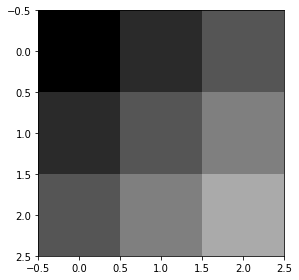

In [1]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

In [10]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    print(f"number_of_classes: {number_of_classes}")
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    print(f"img.shape: {img.shape}")
    expanded_img = np.expand_dims(input_img, axis=0)
    print(f"expanded_img.shape: {expanded_img.shape}")

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor,
                                        number_of_classes)
                
                print(f"upsample_filter_np.shape: {upsample_filter_np.shape}")
                #print(f"upsample_filter_np: {upsample_filter_np}")

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                        output_shape=[1, new_height, new_width, number_of_classes],
                        strides=[1, factor, factor, 1])

                final_result = sess.run(res,
                                feed_dict={upsample_filt_pl: upsample_filter_np,
                                           logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

number_of_classes: 3
img.shape: (3, 3, 3)
expanded_img.shape: (1, 3, 3, 3)
upsample_filter_np.shape: (5, 5, 3, 3)


InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 3, computed = 2
	 [[Node: conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 3, 3, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose/output_shape, _arg_Placeholder_0_0, _arg_Placeholder_1_0_1)]]

Caused by op 'conv2d_transpose', defined at:
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-b1880c8732bf>", line 83, in <module>
    upsampled_img_tf = upsample_tf(factor=3, input_img=img)
  File "<ipython-input-10-b1880c8732bf>", line 75, in upsample_tf
    strides=[1, factor, factor, 1])
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1048, in conv2d_transpose
    name=name)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 486, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 3, computed = 2
	 [[Node: conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 3, 3, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose/output_shape, _arg_Placeholder_0_0, _arg_Placeholder_1_0_1)]]
